# Creating image pipeline for bird's eye view images 

In [55]:
#Importing everything needed for project and testing imports before starting
#To make sure all of my imports are available
import os
import scipy
from scipy import signal
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from collections import deque
import glob
import imageio
import pandas as pd
imageio.plugins.ffmpeg.download()
#Importing everything needed to edit,save and watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from beeprint import pp
%matplotlib inline

In [40]:
#Loading pickled distortion matrix

output_dir = 'output_images/part2/'

with open('camera_dist_pickle.p', mode ='rb')as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']

In [41]:
#Loading all test images
images = glob.glob('test_images/*.jpg')

for idx,fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    image_name = os.path.split(fname)[1]
    write_name = output_dir+'undistored_'+image_name
    cv2.imwrite(write_name,dst)
    print(write_name)
    cv2.imshow('dst',dst)
    cv2.waitKey(500)
cv2.destroyAllWindows()

'''In this step what I attempted to accomplish was taking the test images 
    and removing any distortion from them. Upon looking at them in my file explorer
    it didn't seem that they were distored much inside of the test folder, but for better
    results it's best to distort them from the start.
'''

output_images/part2/undistored_straight_lines1.jpg
output_images/part2/undistored_straight_lines2.jpg
output_images/part2/undistored_test1.jpg
output_images/part2/undistored_test2.jpg
output_images/part2/undistored_test3.jpg
output_images/part2/undistored_test4.jpg
output_images/part2/undistored_test5.jpg
output_images/part2/undistored_test6.jpg


"In this step what I attempted to accomplish was taking the test images \n    and removing any distortion from them. Upon looking at them in my file explorer\n    it didn't seem that they were distored much inside of the test folder, but for better\n    results it's best to distort them from the start.\n"

In [42]:
def undistort(img):
    result = cv2.undistort(img,mtx,dist,None,mtx)
    return result

def create_binary(img,s_thresh=(120,255),sx_thresh=(20,255),l_thresh=(40,255)):
    #Copying image passed in
    img = np.copy(img)
    
    #Convert to HLS color space and seperate the V channel
    
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    # sobelx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255))
    # l_channel_col=np.dstack((l_channel,l_channel, l_channel))
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    channels = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return  binary,channels

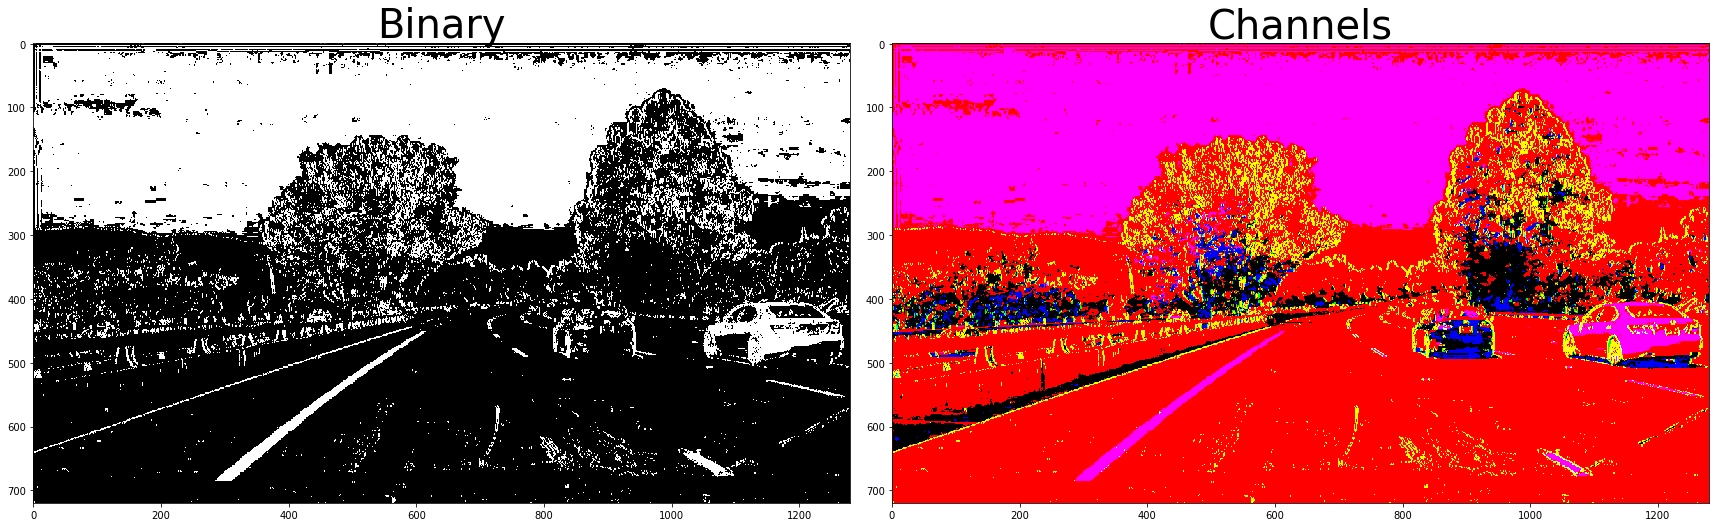

In [43]:
img = plt.imread('test_images/test1.jpg')

shape = img.shape
binary,channels = create_binary(img)
plt.imsave(output_dir+'binary.jpg',binary)
plt.imsave(output_dir+'channels.jpg',channels)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary)
ax1.set_title('Binary', fontsize=40)

ax2.imshow(channels)
ax2.set_title('Channels', fontsize=40)

In [44]:
'''With this function I am creating a birds eye view of the straight on test image
    after finding/setting the points of the image and using cv2.getPerspectiveTransform()
    to finish the heavy lifting.
'''
def warp(img,tobird=True):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    if tobird:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M

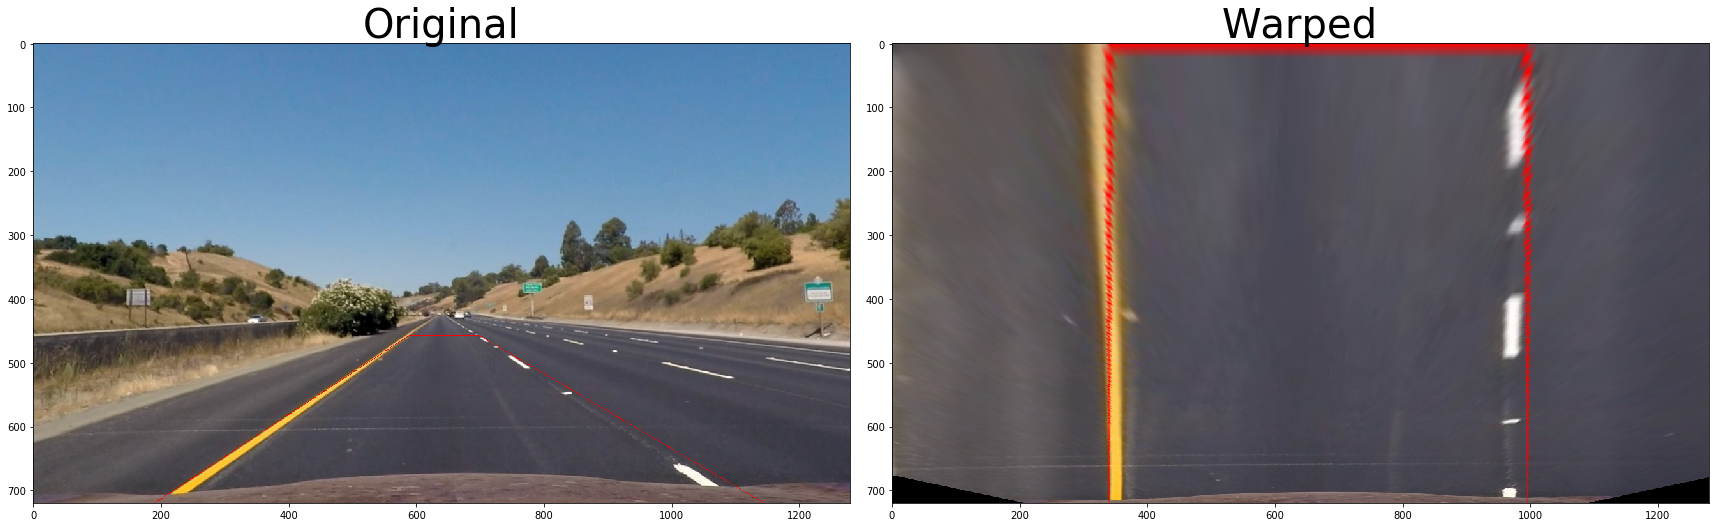

In [45]:
img=plt.imread('test_images/straight_lines1.jpg')
corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
img = cv2.undistort(img, mtx, dist, None, mtx)
imshape = img.shape

corner_tuples=[]
for ind,c in enumerate(corners):
    corner_tuples.append(tuple(corners[ind]))

cv2.line(img, corner_tuples[0], corner_tuples[1], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[1], corner_tuples[2], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[2], corner_tuples[3], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[3], corner_tuples[0], color=[255,0,0], thickness=1)

warped,_ = warp(img) 
plt.imsave(output_dir+'straight_red.jpg',img)
plt.imsave(output_dir+'straight_red_warped.jpg',warped)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Warped', fontsize=40)

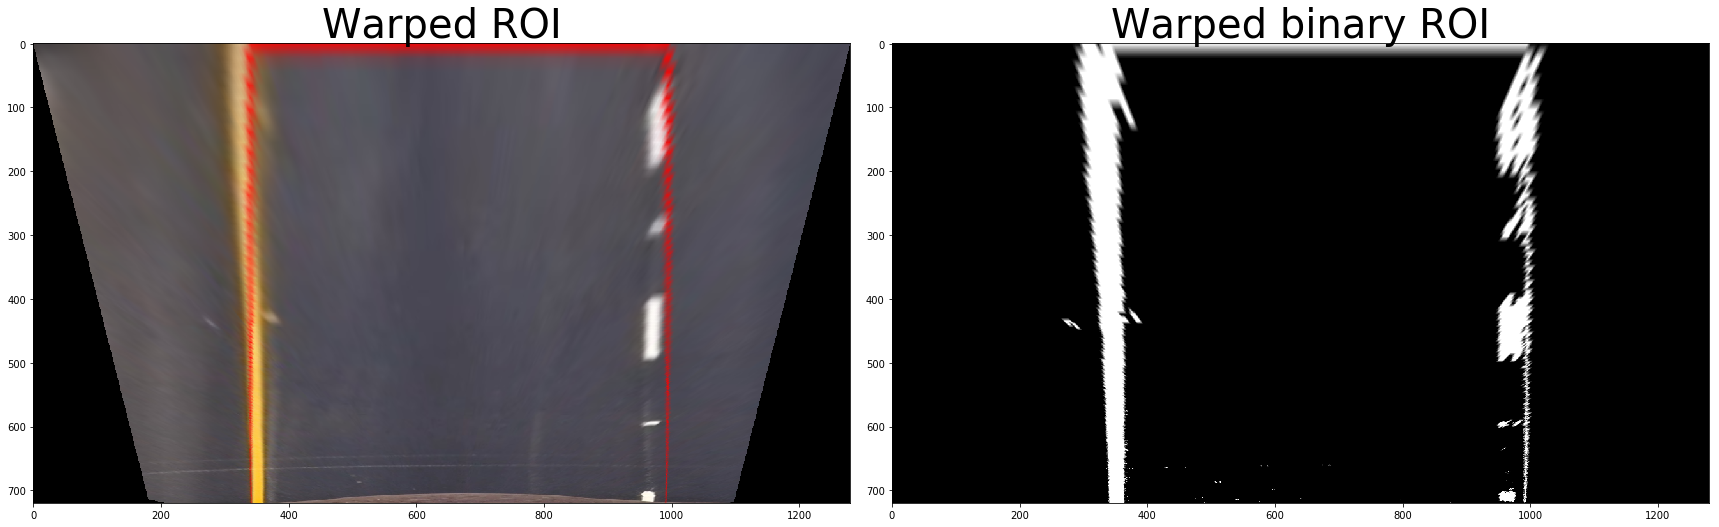

In [46]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def warp_pipeline(img):
    undist = undistort(img)    
    result,_ = warp(undist)
    result = region_of_interest(result)
    return result
    
def warp_binarize_pipeline(img):
    undist = undistort(img)
    binary,_  = create_binary(undist)
    result,_  = warp(binary)
    result = region_of_interest(result)
    return result 

warp_roi = warp_pipeline(img)
warp_binary_roi = warp_binarize_pipeline(img)

plt.imsave(output_dir+'warp_roi.jpg',warp_roi)
plt.imsave(output_dir+'warp_binary_roi.jpg',warp_binary_roi)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warp_roi)
ax1.set_title('Warped ROI', fontsize=40)

ax2.imshow(warp_binary_roi)
ax2.set_title('Warped binary ROI', fontsize=40)

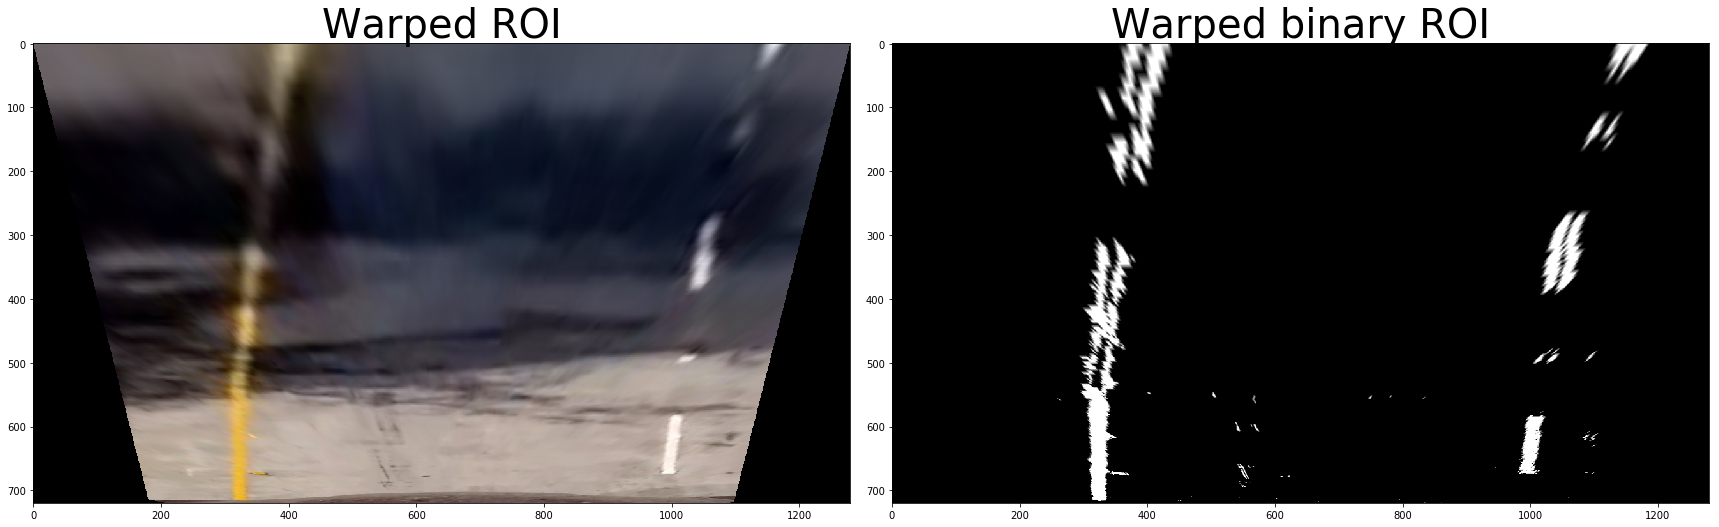

In [47]:
# now back to the test image
img=plt.imread('test_images/test5.jpg')
warped = warp_pipeline(img)
warped_binary = warp_binarize_pipeline(img)

plt.imsave(output_dir+'warp_test5.jpg',warped)
plt.imsave(output_dir+'warp_binary_test5.jpg',warped_binary)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped)
ax1.set_title('Warped ROI', fontsize=40)

ax2.imshow(warped_binary)
ax2.set_title('Warped binary ROI', fontsize=40)

In [48]:
def find_peaks(img,thresh):
    img_half=img[img.shape[0]//2:,:,0]
    data = np.sum(img_half, axis=0)
    filtered = scipy.ndimage.filters.gaussian_filter1d(data,20)
    xs = np.arange(len(filtered))
    peak_ind = signal.find_peaks_cwt(filtered, np.arange(20,300))
    peaks = np.array(peak_ind)
    peaks = peaks[filtered[peak_ind]>thresh]
    return peaks,filtered

def get_next_window(img,center_point,width):
    """
    input: img,center_point,width
        img: binary 3 channel image
        center_point: center of window
        width: width of window
    
    output: masked,center_point
        masked : a masked image of the same size. mask is a window centered at center_point
        center : the mean ofall pixels found within the window
    """
    
    ny,nx,_ = img.shape
    mask  = np.zeros_like(img)
    if (center_point <= width/2): center_point = width/2
    if (center_point >= nx-width/2): center_point = nx-width/2
    
    left  = center_point - width/2
    right = center_point + width/2
    
    vertices = np.array([[(left,0),(left,ny), (right,ny),(right,0)]], dtype=np.int32)
    ignore_mask_color=(255,255,255)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked = cv2.bitwise_and(mask,img)

    hist = np.sum(masked[:,:,0],axis=0)
    if max(hist>10000):
        center = np.argmax(hist)
    else:
        center = center_point
        
    return masked,center

def lane_from_window(binary,center_point,width):
    n_zones=6
    ny,nx,nc = binary.shape
    zones = binary.reshape(n_zones,-1,nx,nc)
    zones = zones[::-1] # start from the bottom slice
    window,center = get_next_window(zones[0],center_point,width)
    
    for zone in zones[1:]:
        next_window,center = get_next_window(zone,center,width)
        window = np.vstack((next_window,window))
    
    return window

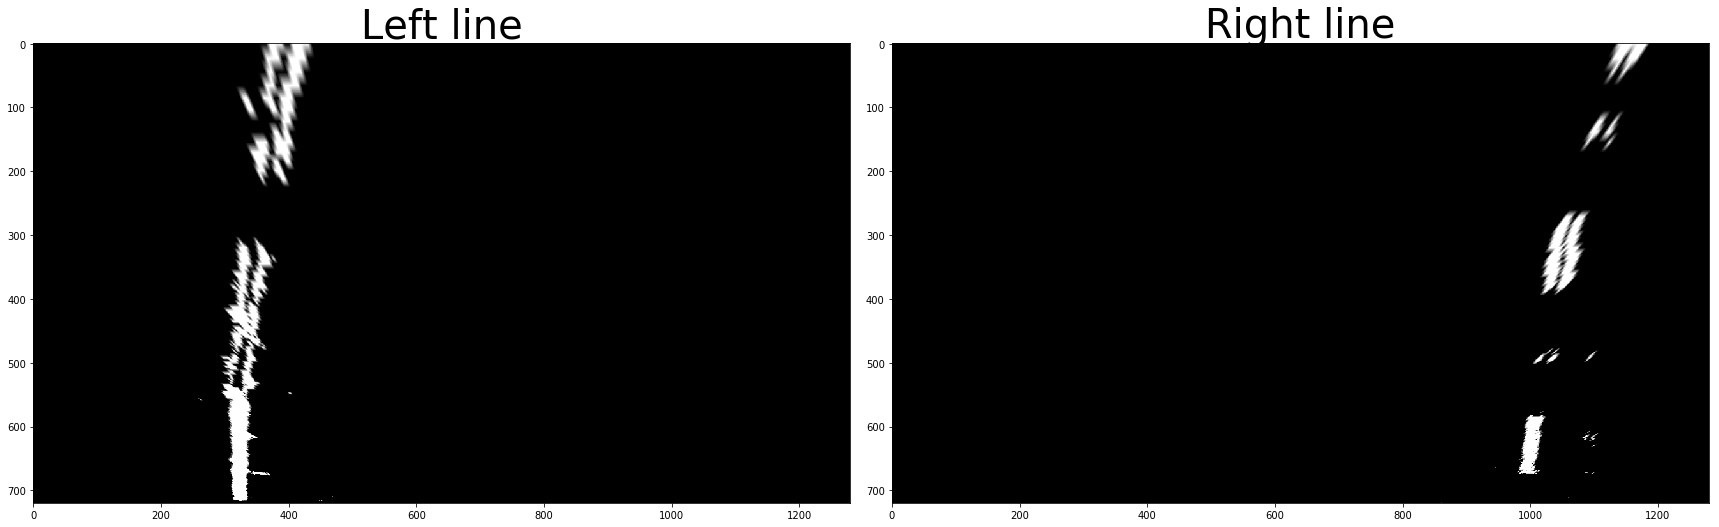

In [49]:
left_binary = lane_from_window(warped_binary,380,300)
right_binary = lane_from_window(warped_binary,1000,300)

plt.imsave(output_dir+'left_line.jpg',left_binary)
plt.imsave(output_dir+'right_line.jpg',right_binary)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(left_binary)
ax1.set_title('Left line', fontsize=40)

ax2.imshow(right_binary)
ax2.set_title('Right line', fontsize=40)

In [105]:
# Defininig a class to receive the characteristics of each line detection in a given image
class Line:
    def __init__(self,n=5):
        # length of queue to store data
        self.n = n
        #number of fits in buffer
        self.n_buffered = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([],maxlen=n)
        #average x values of the fitted line over the last n iterations
        self.avgx = None
        # fit coeffs of the last n fits
        self.recent_fit_coeffs = deque([],maxlen=n)        
        #polynomial coefficients averaged over the last n iterations
        self.avg_fit_coeffs = None  
        # xvals of the most recent fit
        self.current_fit_xvals = [np.array([False])]  
        #polynomial coefficients for the most recent fit
        self.current_fit_coeffs = [np.array([False])]          
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #y values for line fit
        self.fit_yvals = np.linspace(0, 100, num=101)*7.2  # always the same y-range as image
        self.fit_yvals.shape
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # origin (pixels) of fitted line at the bottom of the image
        self.line_pos = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        '''
        #For each y position generate random x position within +/- 50 px
        quadratic_coeff = 3e-4 #arbitrary quadratic coefficient
        self.leftx = np.array([200 + (y*2)*quadratic_coeff + np.random.randint(-50,high=51)
                              for y in self.fit_yvals])
        self.rightx = np.array([900 + (y*2)*quadratic_coeff + np.random.randint(-50,high=51)
                              for y in self.fit_yvals])
        self.leftx=self.leftx[::-1]
        self.rightx=self.rightx[::-1]
        '''

    def set_current_fit_xvals(self):
        yvals = self.fit_yvals
        self.current_fit_xvals = self.current_fit_coeffs[0]*yvals**2 + self.current_fit_coeffs[1]*yvals + self.current_fit_coeffs[2]
        
    def add_data(self):
        self.recent_xfitted.appendleft(self.current_fit_xvals)
        self.recent_fit_coeffs.appendleft(self.current_fit_coeffs)
        assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
        self.n_buffered = len(self.recent_xfitted)
        
    def pop_data(self):        
        if self.n_buffered>0:
            self.recent_xfitted.pop()
            self.recent_fit_coeffs.pop()
            assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
            self.n_buffered = len(self.recent_xfitted)
        
        return self.n_buffered
        
    def set_avgx(self):
        fits = self.recent_xfitted
        if len(fits)>0:
            avg=0
            for fit in fits:
                avg +=np.array(fit)
            avg = avg / len(fits)
            self.avgx = avg
            
    def set_avgcoeffs(self):
        coeffs = self.recent_fit_coeffs
        if len(coeffs)>0:
            avg=0
            for coeff in coeffs:
                avg +=np.array(coeff)
            avg = avg / len(coeffs)
            self.avg_fit_coeffs = avg
    
    def set_allxy(self,lane_candidate):
        self.ally,self.allx = (lane_candidate[:,:,0]>254).nonzero()

    def set_current_fit_coeffs(self):
        self.current_fit_coeffs = np.polyfit(self.ally, self.allx, 2)
    
    def get_diffs(self):
        if self.n_buffered>0:
            self.diffs = self.current_fit_coeffs - self.avg_fit_coeffs
        else:
            self.diffs = np.array([0,0,0], dtype='float')                 
            
    def set_radius_of_curvature(self):
        # Define y-value where we want radius of curvature in meters (choose bottom of the image)
        '''Using an adaptation of the formula given in the lessons
            ym_per_pix = 30/720 # meters per pixel in y dimension
            xm_per_pix = 3.7/700 # meters per pixel in x dimension
            left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2) #Because we only need the left side here
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        '''
        y_eval = max(self.fit_yvals)
        ym_per_pix = 30/720
        xm_per_pix = 3.7/700
        left_fit_cr = np.polyfit(self.fit_yvals*ym_per_pix, self.current_fit_xvals*xm_per_pix, 2)
        right_fit_cr = np.polyfit(self.fit_yvals*ym_per_pix, self.current_fit_xvals*xm_per_pix, 2)
        if self.avg_fit_coeffs is not None:
            self.radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
                
                
                        
            
    def set_line_base_pos(self):
        y_eval = max(self.fit_yvals)
        self.line_pos = self.current_fit_coeffs[0]*y_eval**2 \
                        +self.current_fit_coeffs[1]*y_eval \
                        + self.current_fit_coeffs[2]
        basepos = 640
        
        self.line_base_pos = (self.line_pos - basepos)*3.7/600.0 # 3.7 meters is about 600 pixels in the x direction

    # here come sanity checks of the computed metrics
    def accept_lane(self):
        flag = True
        maxdist = 2.8  # distance in meters from the lane
        if(abs(self.line_base_pos) > maxdist ):
            print('lane too far away')
            flag  = False        
        if(self.n_buffered > 0):
            relative_delta = self.diffs / self.avg_fit_coeffs
            # allow maximally this percentage of variation in the fit coefficients from frame to frame
            if not (abs(relative_delta)<np.array([0.7,0.5,0.15])).all():
                print('fit coeffs too far off [%]',relative_delta)
                flag=False
                
        return flag
    
    def update(self,lane):
        self.set_allxy(lane)
        self.set_current_fit_coeffs()
        self.set_current_fit_xvals()
        self.set_radius_of_curvature()
        self.set_line_base_pos()
        self.get_diffs()
        if self.accept_lane():
            self.detected=True
            self.add_data()
            self.set_avgx()
            self.set_avgcoeffs()            
        else:
            self.detected=False            
            self.pop_data()
            if self.n_buffered>0:
                self.set_avgx()
                self.set_avgcoeffs()
                    
        return self.detected,self.n_buffered
    
def get_binary_lane_image(img,line,window_center,width=300):
    if line.detected:
        window_center=line.line_pos
    else:
        peaks,filtered = find_peaks(img,thresh=3000)
        if len(peaks)!=2:
            print('Trouble ahead!Pull Over! '+ str(len(peaks)) +' lanes detected!')
            plt.imsave('troublesome_image.jpg',img)                        
            
        peak_ind = np.argmin(abs(peaks-window_center))
        peak  = peaks[peak_ind]
        window_center = peak
    
    lane_binary = lane_from_window(img,window_center,width)
    return lane_binary

In [104]:
pp(Line())

instance(Line):
  allx: None,
  ally: None,
  avg_fit_coeffs: None,
  avgx: None,
  current_fit_coeffs: [array([False], dtype=bool)],
  current_fit_xvals: [array([False], dtype=bool)],
  detected: False,
  diffs: array([ 0.,  0.,  0.]),
  fit_yvals: array([   0. ,    7.2,   14.4,   21.6,   28.8,   36. ,   43.2,   50.4,
         57.6,   64.8,   72. ,   79.2,   86.4,   93.6,  100.8,  108. ,
        115.2,  122.4,  129.6,  136.8,  144. ,  151.2,  158.4,  165.6,
        172.8,  180. ,  187.2,  194.4,  201.6,  208.8,  216. ,  223.2,
        230.4,  237.6,  244.8,  252. ,  259.2,  266.4,  273.6,  280.8,
        288. ,  295.2,  302.4,  309.6,  316.8,  324. ,  331.2,  338.4,
        345.6,  352.8,  360. ,  367.2,  374.4,  381.6,  388.8,  396. ,
        403.2,  410.4,  417.6,  424.8,  432. ,  439.2,  446.4,  453.6,
        460.8,  468. ,  475.2,  482.4,  489.6,  496.8,  504. ,  511.2,
        518.4,  525.6,  532.8,  540. ,  547.2,  554.4,  561.6,  568.8,
        576. ,  583.2,  590.4,  597.6,  

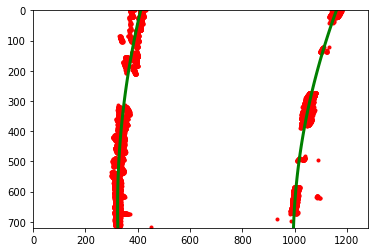

In [106]:
left=Line()
right=Line()
right.fit_yvals.shape


detected_l,n_buffered_left = left.update(left_binary)
detected_r,n_buffered_right = right.update(right_binary)

leftx = left.allx
left_fitx = left.current_fit_xvals
yvals_l = left.ally
#print("THis is yvals_1:", yvals_l)
rightx = right.allx
#print("This is rightx:",rightx)
'''
#This is just a test

ym_per_pix = 30/720
xm_per_pix = 3.7/700
left_fit_cr = np.polyfit(yvals_l*ym_per_pix,leftx*xm_per_pix,2 )
right_fit_cr = np.polyfit(yvals_l*ym_per_pix,leftx*xm_per_pix,2 )

left_curverad = ((1 + (2*left_fit_cr[0]*yvals_l*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*yvals_l*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
print("This is left_curverad", left_curverad)
print("This is right_curverad", right_curverad)
'''
right_fitx = right.current_fit_xvals
#print(right_fitx)

yvals_r = right.ally

yvals = left.fit_yvals

plt.plot(rightx, yvals_r, '.', color='red')
plt.plot(right_fitx, yvals, color='green', linewidth=3)

plt.plot(leftx, yvals_l, '.', color='red')
plt.plot(left_fitx, yvals, color='green', linewidth=3)

plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.gca().invert_yaxis()
plt.savefig(output_dir+'fitted_lines.jpg')
plt.show()

In [107]:
def project_lane_lines(img,left_fitx,right_fitx,yvals):
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    undist = undistort(img)    
    unwarp,Minv = warp(img,tobird=False)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [112]:
def process_image(img):
    global left
    global right
    undist = undistort(img)
    binary,_  = create_binary(undist)
    warped,_  = warp(binary)
    warped_binary = region_of_interest(warped)
    
    window_center_l = 340
    if left.detected:
        window_center_l = left.line_pos        
    left_binary = get_binary_lane_image(warped_binary,left,window_center_l,width=300)
    
    window_center_r = 940
    if right.detected:
        window_center_r = right.line_pos        
    right_binary = get_binary_lane_image(warped_binary,right,window_center_r,width=300)
    
    detected_l,n_buffered_left = left.update(left_binary)
    detected_r,n_buffered_right = right.update(right_binary)    
    
    left_fitx = left.avgx
    right_fitx = right.avgx
    yvals = left.fit_yvals
    lane_width = 3.7
    off_center = -100*round(0.5*(right.line_base_pos-lane_width/2) +  0.5*(abs(left.line_base_pos)-lane_width/2),2)
    
    result = project_lane_lines(img,left_fitx,right_fitx,yvals)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    str1 = str('distance from center: '+str(off_center)+'cm')
    cv2.putText(result,str1,(430,630), font, 1,(0,0,255),2,cv2.LINE_AA)
    if left.radius_of_curvature and right.radius_of_curvature:
        curvature = 0.5*(round(right.radius_of_curvature/1000,1) + round(left.radius_of_curvature/1000,1))
        str2 = str('radius of curvature: '+str(curvature)+'km')
        cv2.putText(result,str2,(430,670), font, 1,(0,0,255),2,cv2.LINE_AA)    
    
    return result

Trouble ahead!Pull Over! 6 lanes detected!
Trouble ahead!Pull Over! 6 lanes detected!


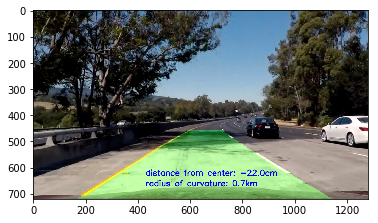

In [113]:
img = plt.imread('test_images/test5.jpg')
left = Line(7)
right = Line(7)

result = process_image(img)
result = process_image(img)

plt.figure()
plt.imshow(result)
plt.show()
plt.imsave(output_dir+'project_test5.jpg',result)